In [ ]:
%cd '/content/drive/My Drive/ASC'

/content/drive/My Drive/ASC


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import torchvision
from torchvision import *
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import time
import copy
import os

In [3]:
!pip install git+https://github.com/aleju/imgaug
from imgaug import augmenters as iaa
import imgaug as ia

  Cloning https://github.com/aleju/imgaug to /tmp/pip-req-build-7zao_cbd
  Running command git clone -q https://github.com/aleju/imgaug /tmp/pip-req-build-7zao_cbd
  Created wheel for imgaug: filename=imgaug-0.4.0-cp36-none-any.whl size=971107 sha256=747015b57759ab87227b30e1fb342826466ed70c25741e58de54c4cce8de94bf
  Stored in directory: /tmp/pip-ephem-wheel-cache-tn5mk7j1/wheels/9c/f6/aa/41dcf2f29cc1de1da4ad840ef5393514bead64ac9e644260ff
Successfully built imgaug
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.4.0 which is incompatible.
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9


In [4]:
class ImgAugTransform:
  def __init__(self):
    self.aug = iaa.Sequential([
        iaa.Scale((224, 224)),
        iaa.Sometimes(0.25, iaa.GaussianBlur(sigma=(0, 3.0))),
        iaa.Fliplr(0.5),
        iaa.Affine(rotate=(-20, 20), mode='symmetric'),
        iaa.Sometimes(0.25,
                      iaa.OneOf([iaa.Dropout(p=(0, 0.1)),
                                 iaa.CoarseDropout(0.1, size_percent=0.5)])),
        iaa.AddToHueAndSaturation(value=(-10, 10), per_channel=True)
    ])
      
  def __call__(self, img):
    img = np.array(img)
    return self.aug.augment_image(img)

In [5]:
batch_size = 32
learning_rate = 1e-3
IMAGE_SIZE = 224
NUM_CLASSES = 6

import PIL
import torchvision
#transforms = transforms.Compose(
#[   transforms.RandomResizedCrop((IMAGE_SIZE, IMAGE_SIZE)),
 #   transforms.RandomHorizontalFlip(),
 #   transforms.ToTensor()
   # transforms.Normalize(IMG_MEAN, IMG_STD)
   # transforms.ToTensor()
#])

transforms = ImgAugTransform()
transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224,224)),
    torchvision.transforms.ColorJitter(hue=.05, saturation=.05),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomRotation(20, resample=PIL.Image.BILINEAR),
    torchvision.transforms.ToTensor()
])

train_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/ASC/Final/Train', transform=transforms)
test_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/ASC/Final/Test', transform=transforms)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

#def imshow(inp, title=None):
    
   # inp = inp.cpu() if device else inp
   # inp = inp.numpy().transpose((1, 2, 0))
    
   # mean = np.array([0.485, 0.456, 0.406])
   # std = np.array([0.229, 0.224, 0.225])
    #inp = std * inp + mean
   # inp = np.clip(inp, 0, 1)
    
   # plt.imshow(inp)
  #  if title is not None:
      #  plt.title(title)
    #plt.pause(0.001)
    
#images, labels = next(iter(train_dataloader)) 
#print("images-size:", images.shape)

#out = torchvision.utils.make_grid(images)
#print("out-size:", out.shape)

#imshow(out, title=[train_dataset.classes[x] for x in labels])



/usr/local/lib/python3.6/dist-packages/imgaug/imgaug.py:188: DeprecationWarning: Function `Scale()` is deprecated. Use `Resize` instead. Resize has the exactly same interface as Scale.
  warn_deprecated(msg, stacklevel=3)


In [6]:
import torchvision.models as models
import torch.nn as nn

densenet = models.densenet161(pretrained=True)

#resnet50 = models.resnet50(pretrained=True)


#resnet50.avg_pool = nn.AdaptiveAvgPool2d(1)
#resnet50.last_linear = nn.Sequential(
  #  nn.BatchNorm1d(128),
  #  nn.Dropout(p=0.25),
  #  nn.Linear(in_features=128, out_features=128),
 #   nn.ReLU(),
  #  nn.BatchNorm1d(128, eps=1e-05, momentum=0.1),
  #  nn.Dropout(p=0.5),
  #  nn.Linear(in_features=128, out_features=6),   )


densenet = densenet.cuda() if device else densenet

Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.cache/torch/hub/checkpoints/densenet161-8d451a50.pth


In [7]:
criterion = nn.CrossEntropyLoss()
#criterion = nn.BCELoss()
optimizer = optim.Adam(densenet.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.1)
use_cuda = torch.cuda.is_available()

def accuracy(out, labels):
    _,pred = torch.max(out, dim=1)
    return torch.sum(pred==labels).item()

num_ftrs = densenet.classifier.in_features
densenet.classifier = nn.Linear(num_ftrs, 6)
densenet.classifier = densenet.classifier.cuda() if use_cuda else densenet.classifier

In [8]:
n_epochs = 5
print_every = 10
valid_loss_min = np.Inf
val_loss = []
val_acc = []
train_loss = []
train_acc = []
total_step = len(train_dataloader)
for epoch in range(1, n_epochs+1):
    running_loss = 0.0
    correct = 0
    total=0
    print(f'Epoch {epoch}\n')
    for batch_idx, (data_, target_) in enumerate(train_dataloader):
        data_, target_ = data_.to(device), target_.to(device)
        optimizer.zero_grad()
        
        outputs = densenet(data_)
        loss = criterion(outputs, target_)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _,pred = torch.max(outputs, dim=1)
        correct += torch.sum(pred==target_).item()
        total += target_.size(0)
        if (batch_idx) % 20 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch, n_epochs, batch_idx, total_step, loss.item()))
    train_acc.append(100 * correct / total)
    train_loss.append(running_loss/total_step)
    print(f'\ntrain-loss: {np.mean(train_loss):.4f}, train-acc: {(100 * correct/total):.4f}')
    batch_loss = 0
    total_t=0
    correct_t=0
    with torch.no_grad():
        densenet.eval()
        for data_t, target_t in (test_dataloader):
            data_t, target_t = data_t.to(device), target_t.to(device)
            outputs_t = densenet(data_t)
            loss_t = criterion(outputs_t, target_t)
            batch_loss += loss_t.item()
            _,pred_t = torch.max(outputs_t, dim=1)
            correct_t += torch.sum(pred_t==target_t).item()
            total_t += target_t.size(0)
        val_acc.append(100 * correct_t/total_t)
        val_loss.append(batch_loss/len(test_dataloader))
        network_learned = batch_loss < valid_loss_min
        print(f'validation loss: {np.mean(val_loss):.4f}, validation acc: {(100 * correct_t/total_t):.4f}\n')

        
        if network_learned:
            valid_loss_min = batch_loss
            torch.save(densenet.state_dict(), 'resnet.pt')
            print('Improvement-Detected, save-model')
    densenet.train()

Epoch 1

Epoch [1/5], Step [0/209], Loss: 1.8029
Epoch [1/5], Step [20/209], Loss: 1.2101
Epoch [1/5], Step [40/209], Loss: 1.3165
Epoch [1/5], Step [60/209], Loss: 1.3320
Epoch [1/5], Step [80/209], Loss: 1.3436
Epoch [1/5], Step [100/209], Loss: 1.2629
Epoch [1/5], Step [120/209], Loss: 1.3950
Epoch [1/5], Step [140/209], Loss: 1.2332
Epoch [1/5], Step [160/209], Loss: 1.0163
Epoch [1/5], Step [180/209], Loss: 1.2607
Epoch [1/5], Step [200/209], Loss: 1.3596

train-loss: 1.3209, train-acc: 45.8783
validation loss: 1.8372, validation acc: 16.6063

Improvement-Detected, save-model
Epoch 2

Epoch [2/5], Step [0/209], Loss: 1.2175
Epoch [2/5], Step [20/209], Loss: 1.0608
Epoch [2/5], Step [40/209], Loss: 1.2782
Epoch [2/5], Step [60/209], Loss: 1.2875
Epoch [2/5], Step [80/209], Loss: 1.1861
Epoch [2/5], Step [100/209], Loss: 1.2103
Epoch [2/5], Step [120/209], Loss: 1.0351
Epoch [2/5], Step [140/209], Loss: 1.2031
Epoch [2/5], Step [160/209], Loss: 1.2820
Epoch [2/5], Step [180/209], Lo

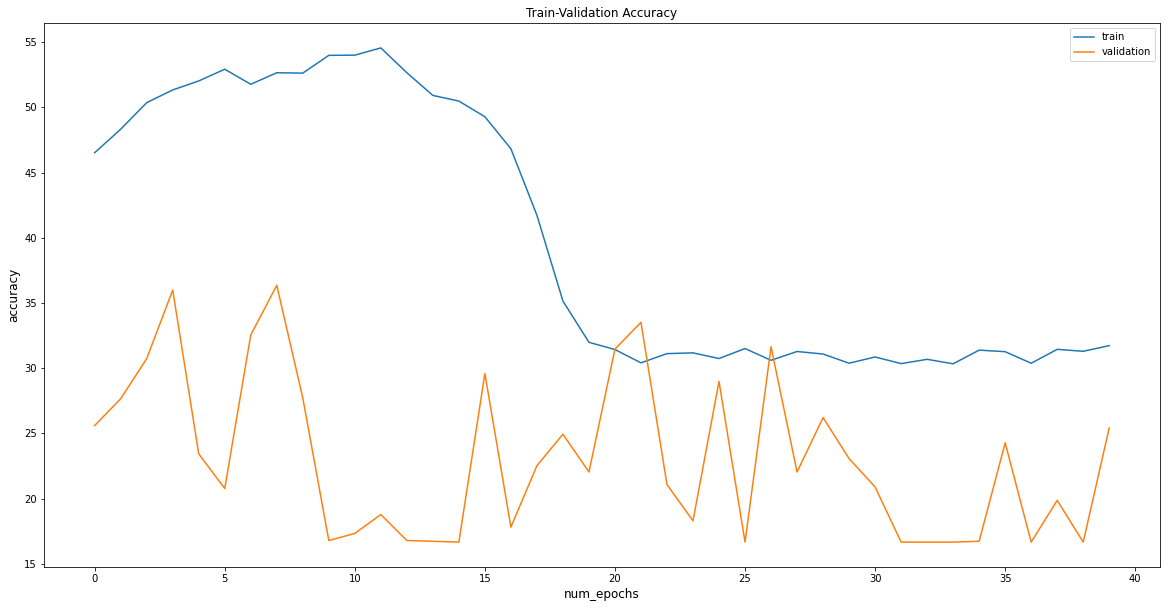

In [ ]:
fig = plt.figure(figsize=(20,10))
plt.title("Train-Validation Accuracy")
plt.plot(train_acc, label='train')
plt.plot(val_acc, label='validation')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('accuracy', fontsize=12)
plt.legend(loc='best')